# Chapter 2: Attention and Transformers from Scratch

This chapter covers:

* How the attention mechanism uses query, key, and value to assign weights to elements in a sequence   
* Encoder-only, decoder-only, and encoder-decoder Transformers  
* Building a Transformer from scratch for language translation  
* Understanding word embedding and positional encoding   
* Training a Transformer from scratch to translate German to English  
* Using the trained Transformer to translate German phrases into English  
* Visualizing attention among words in German and English phrases

Understanding attention and Transformers is crucial for text-to-image generation for two important reasons.

First, one of the two main methods of text-to-image generation is based on Transformers explicitly. As you'll see later in Chapter 16 of this book, OpenAI's DALL-E treats text-to-image generation as a sequence-prediction problem with a Transformer.  Specifically, an image is broken into multiple patches (for example, into a 16 by 16 grid, hence 16X16=256 patches). These patches are then ordered into a sequence: the top left patch first, the patch to the right next, and so on. Based on a text prompt, the trained Transformer in DALL-E predicts the first patch in the image. In the second iteration, the Transformer predicts the second patch based on the text prompt and the first patch. In the third iteration, the Transformer predicts the third patch based on the text prompt and the first two patches. We repeat the process until all 256 patches in the images are generated. Therefore, in order to understand this first method, we need to have a deep understanding of how attention and Transformers work (as you'll see later in this chapter, the attention mechanism is the key building block of a Transformer).

Second, even though the second method of text-to-image generation, diffusion models, is not explicitly based on Transformers, attention and Transformers are working behind the scenes. The attention mechanism and Transformers are crucial to understanding diffusion models because they provide the foundational architecture and computational framework that enable the model's advanced capabilities. The attention mechanism allows the denoising U-Net model (a key component of any diffusion models) to selectively focus on different parts of the input data when generating output. This selective focus is vital for capturing relevant information and ignoring irrelevant parts, leading to better context understanding and more accurate predictions. More importantly, when generating images from text prompts, diffusion models rely on a multi-modal Transformer: contrastive language image pre-training (CLIP). Specifically, CLIP encodes both text descriptions and images into a shared latent space, which is crucial for diffusion models to generate images that are not only high in quality but also closely aligned with the textual descriptions. 

For these two reasons, the book starts with coding the attention mechanism and the Transformer architecture from scratch. In this chapter, you’ll learn to implement the attention mechanism and a Transformer based on the paper Attention Is All You Need, which first proposed the Transformer architecture. The Transformer, once trained, can handle translations between any two languages (such as German to English or English to Chinese). In particular, you'll explore the inner workings of the attention mechanism, including the roles of query, key, and value vectors, and the computation of scaled dot product attention (SDPA). You'll construct an encoder layer by integrating layer normalization and residual connection into a multi-head attention layer and combining it with a feed-forward layer. You'll then stack six of these encoder layers to form the encoder. Similarly, you'll develop a decoder in the Transformer that is capable of generating translation one token at a time, based on previous tokens in the translation and the encoder's output. This groundwork will equip you with the knowledge to train a Transformer for translations between any two languages. You'll then train the Transformer using a dataset containing over 29,000 German-to-English translations. You'll witness the trained model translating common German phrases to English with an accuracy comparable to using Google Translate.

Finally, you'll visualize both self-attention and cross-attention in example German and English sentences. 

We'll use the very first pair of German-to-English translation in our training set as the example. The German phrase is "Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche." The corresponding English translation is "Two young, white males are outside near many bushes." We first look at the encoder self-attention, and in one of the heads, in one of the encoder layers, the self-attention is shown in Figure 2.1.

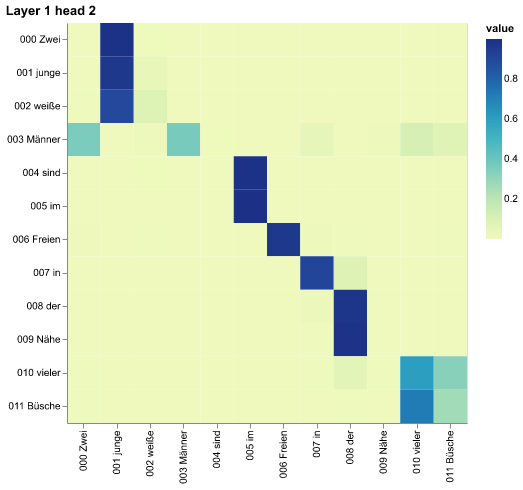

Figure 2.1: Self-attention in the German phrase "Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche"

The self-attention is the strongest along the main diagonal, which means most German words are strongly related to itself. However, we also notice that some words are meaningfully related to other words in the sentence. For example, the word "junge" is related strongly to "Zwei junge weiße." Further, "vieler" and "Büsche" are paying attention to each other.

The self-attention in the decoder is shown in Figure 2.2.

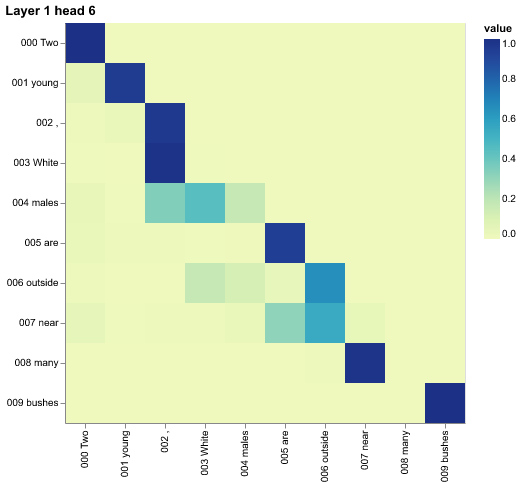

Figure 2.2: Self attention in the English translation "Two young, white males are outside near many bushes."

The words "Two" and "young" are closely related. The word "males" is related to "," and "white".

Finally, the cross attention between the German phrase and the corresponding English translation is shown in Figure 2.3.

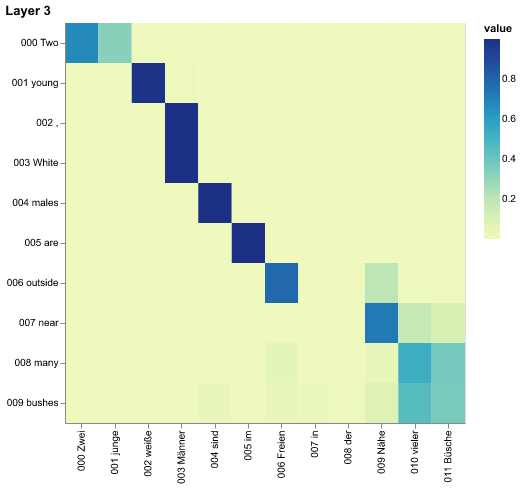

Figure 2.3: Cross attention between the German phrase and the corresponding English translation.

The English word "Two" is related to the two German words "Zwei junge". The German word "Männer" is related to two English tokens "," and "white". The English token "near" is related to German tokens "Nähe vieler Büsche". These are all meaningful relations between the two languages. This indicates that the attention mechanism in the trained model is able to identify the relation between tokens in two different sentences.

# 1	An Overview of Attention and Transformers 
In this section, you'll explore what a Transformer is and how the attention mechanism works. 

## 1.1	How self-attention and cross-attention work?

The attention mechanism is an algorithm designed to compute the relationships between any two elements in a sequence. It assigns scores to indicate how one element is related to all other elements (including itself) within the sequence. A higher score signifies a stronger relationship between the two elements. In Natural Language Processing (NLP), the attention mechanism enables the model to meaningfully relate one word to other words in a sentence.

To illustrate, let's consider an example from the seminal 2017 paper "Attention is All You Need" by a team of Google researchers. The authors introduced the Transformer architecture, utilizing an attention-based mechanism to tackle machine language translation tasks (such as translating German to English or English to French). Figure 2.4 below depicts the Transformer architecture, with the encoder on the left side and the decoder on the right side.

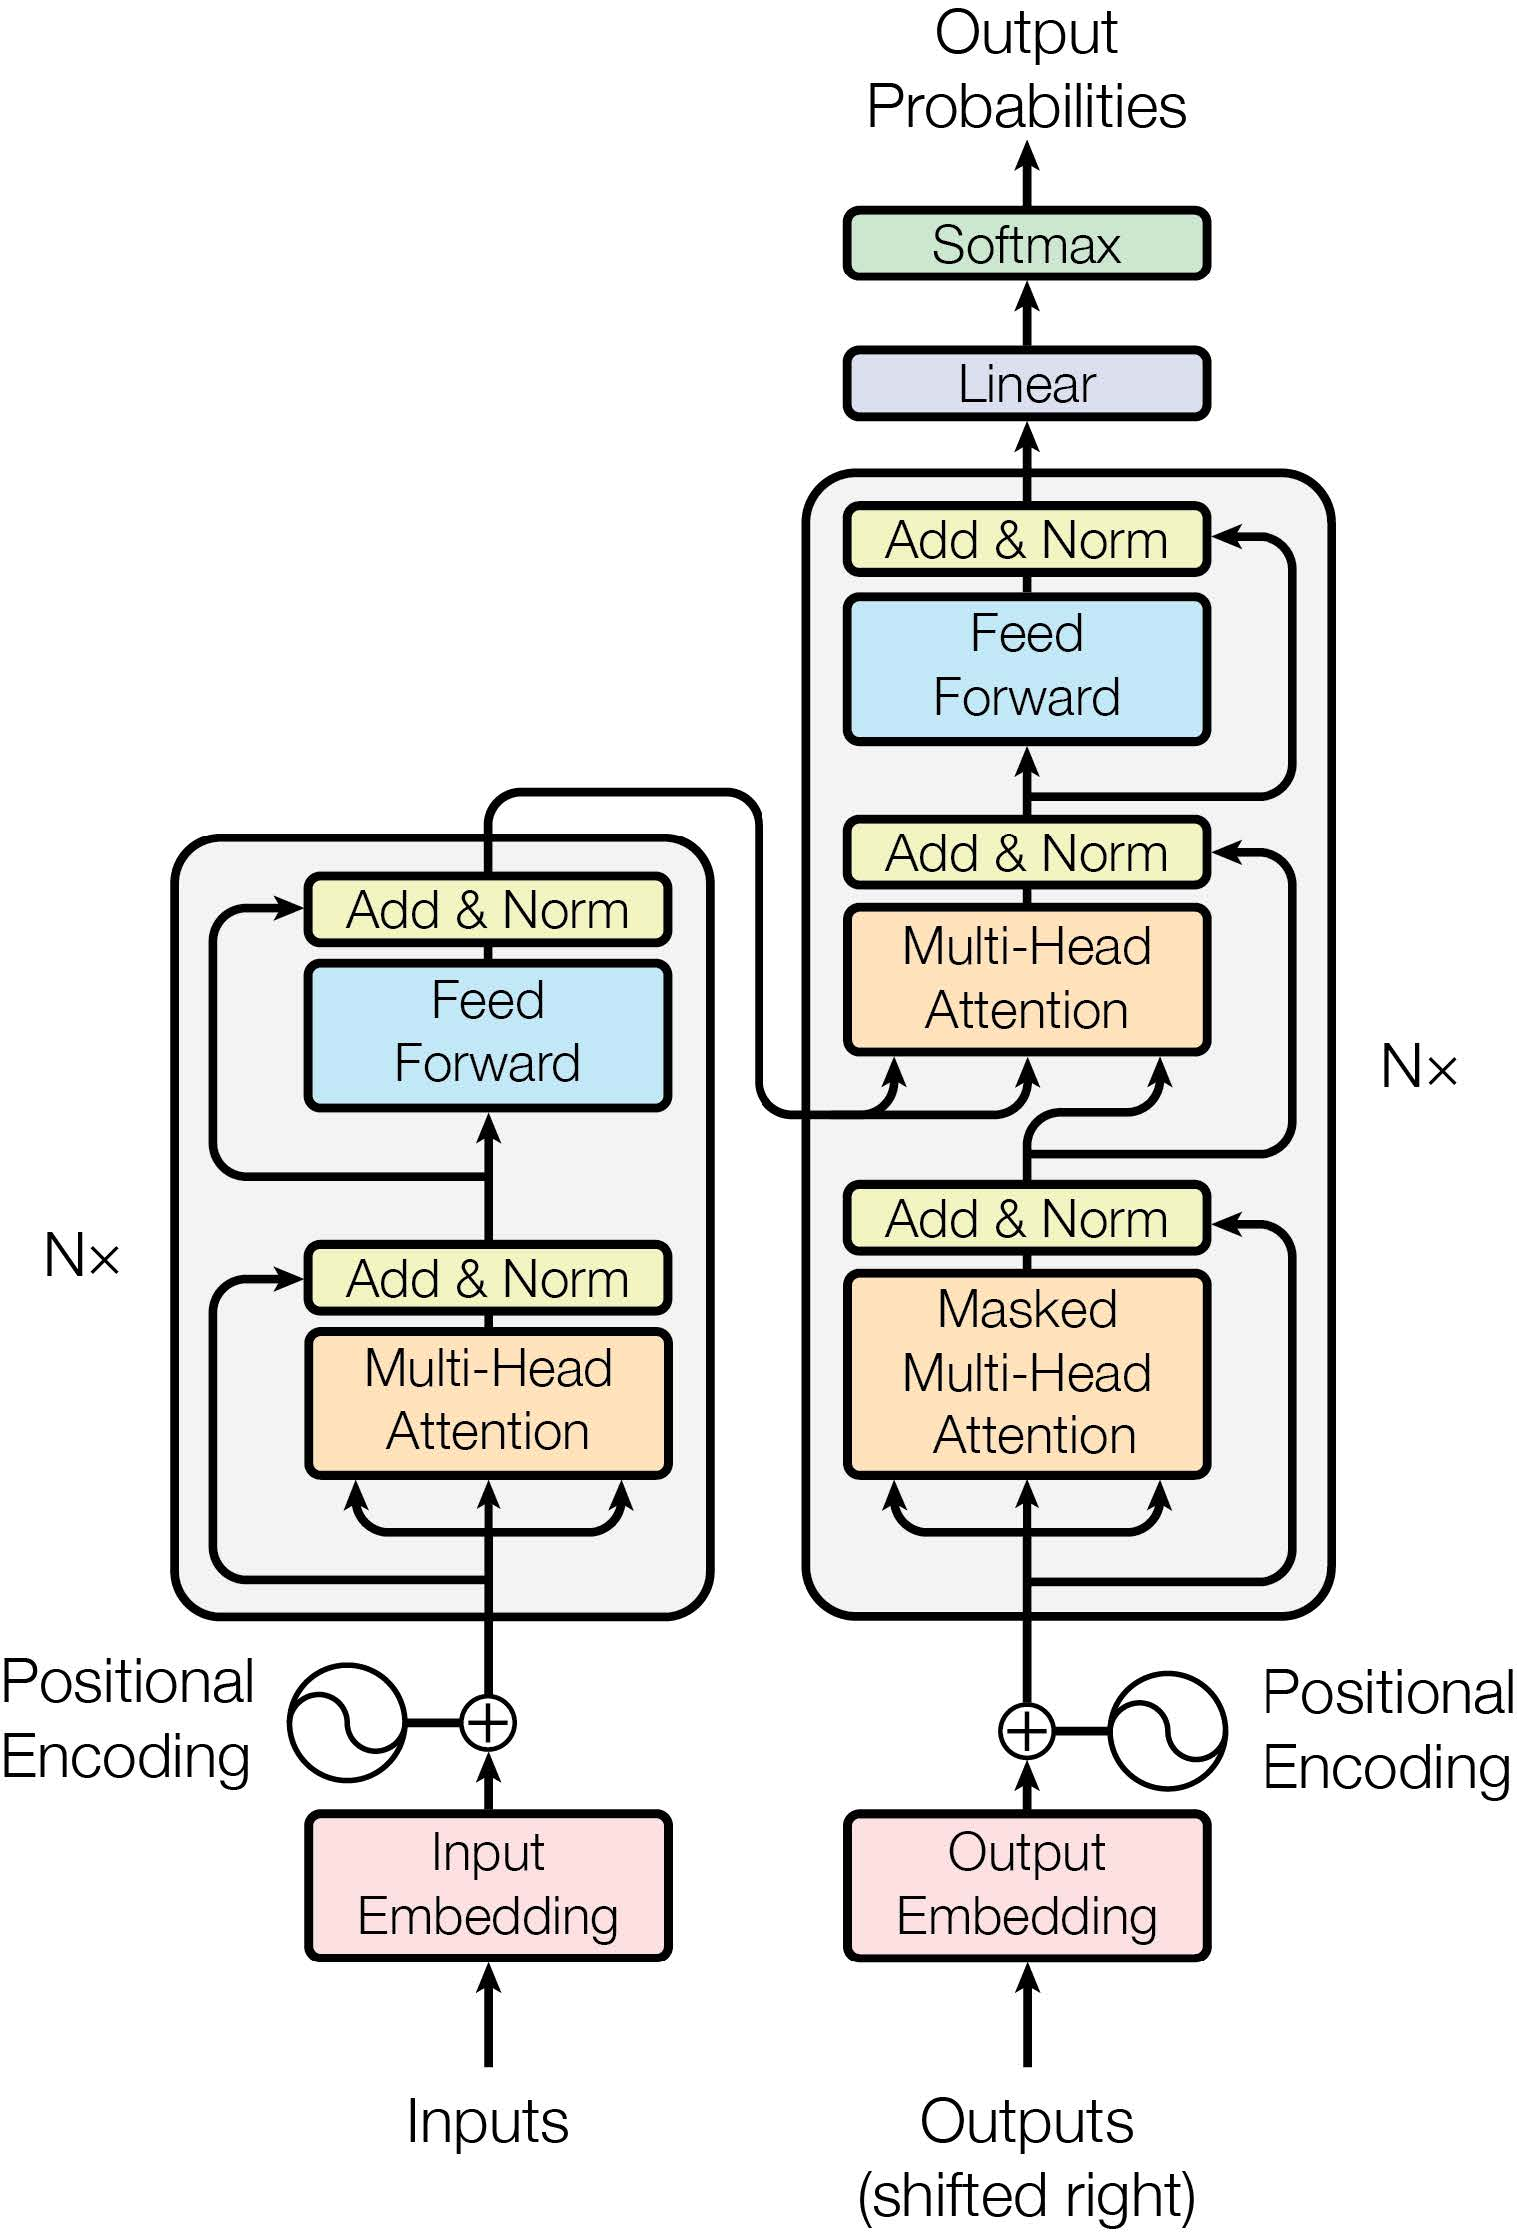
Figure 2.4. The Transformer Architecture (Source: Attention Is All You Need, Vaswani et al 2017)

The encoder in the transformer converts a German phrase such as "Wie geht es dir?" into a continuous vector representation that holds the meaning of the original phrase. The decoder in the transformer then takes the vector representation and converts it to the English translation "How are you?" The encoder's job is to extract the meaning of the original German phrase. The decoder will look at the vector representation and come up with an English translation. 

Here is how the encoder in the transformer extracts the meaning of the German phrase. First, the model converts German and English sentences into tokens. Tokens are words or parts of words that act as semantic units in a language. For example, "Wie geht es dir?" has five tokens: ['Wie', 'geht', 'es', 'dir', '?']. On the other hand, "How are you?" has a set of four tokens: ['How', 'are', 'you', '?']. 

Since machine learning models cannot process text directly, we need to convert text into numbers before feeding them to the models. The obvious solution is the one-hot variables. For example, there are 10837 distinct English tokens and 
19214 unique German tokens in the translation example we'll encounter later in this chapter. If we use one-hot variables, each German  token is represented by a vector with a length of 19214 with 1 in one position and 0 in all others. The
sentence "Wie geht es dir?" is represented by a matrix of 5 by 19214, where 5 is the number of tokens in the sentence and 19214 is the dimension of each token represented by a one-hot vector. However, using a vector with a dimension of 19214 to represent a token is inefficient: there are too many parameters in the model and this reduces the training speed. Instead, the first job of the encoder is to convert one-hot variables to word embedding: the encoder in the Transformer uses a continuous vector of length, say, 256, to represent the 19214 tokens. After  word- embedding, the 
sentence "Wie geht es dir?" is represented by a matrix of 5 by 256. 

The encoder also uses the positional encoding (a technique
for determining the relative or absolute position of elements within a sequence) to capture the ordering of words in the input sequence. Specifically, the positional encoding layer uses the following sine and cosine functions:
$$PE_{(pos,2i)}=sin(\frac{pos}{10000^{2i/d_{model}}})$$
$$PE_{(pos,2i+1)}=cos(\frac{pos}{10000^{2i/d_{model}}})$$
The encoder in the transformer calculates a vector using the sine function for even indexes and another vector using the cosine function for odd indexes. The positional encoding is then added to the sequence’s word embeddings before we feed the sum to the attention layers. For the example sentence "Wie geht es dir?"," the encoder generates a word embedding and a positional embedding, each with a dimension of 5 by 256. The encoder adds the two embeddings together to obtain one single matrix with a dimension of 5 by 256 before feeding the sum to attention layers. The encoder then uses the attention mechanism to gradually convert the inputs into an abstract representation (in the form of a PyTorch tensor) before passing it to the decoder. 

While there are different ways to calculate attention, we’ll use the most common method, the scaled dot product attention (SDPA). This mechanism is also called self-attention due to the fact that the algorithm calculates how a word attends to all words in the sequence, including the word itself. Specifically, the attention weights are calculated by first projecting the inputs into three neural networks to obtain query Q, key K, and value V. The values in these three neural networks are learned during the training process from data. However, the mechanism can also be used to calculate the relation (i.e., cross-attention) between two different sequences. In this chapter, the decoder will calculate the cross-attention between the five tokens in the German phrase "Wie geht es dir?" and its English translation  "How are you?" 

The method of using query, key, and value to calculate attention comes from retrieval systems. For example, you may go to a public library to search for a book. You can type in, say, "machine learning in finance," in the library's search engine. In this case, the query is "machine learning in finance." The keys are the book titles, book descriptions, and so on. The library's retrieval system will recommend a list of books (values) for you based on the similarities between the query and the keys. Naturally, books with phrases "machine learning" or "finance" or both in titles or descriptions come up on top while books with neither phrase in the title or description will not show up because these books will be assigned a low matching score. 

Similarly, in the attention mechanism, we look at the similarities between the projected query and key vectors. The scaled dot product attention calculates the dot product of the query and key vectors. If the two vectors are similar to each other, the dot product is high and vice versa. We then calculate the attention score as follows: 
$$AttentionScore(Q,K)=\frac{Q* K_{transpose}}{\sqrt{d_k}}$$
where $d_k$ is the dimension of the key, and in our example, $d_k=256$. We scale the dot product of query and key by the dimension of the key to stabilize training.

We then apply the softmax function on the attention scores so that the total attention of a word with respect to all other words in the sentence adds up to 100%, and multiply the attention weights by the value vector V. 
The attention is calculated by using the formula:
$$Attention(Q,K,V)=softmax(\frac{Q* K_{transpose}}{\sqrt{d_k}})* V$$

Further, instead of using one set of query, key, and value vectors, the transformer model uses a concept called multi-head attention. The 256-dimensional query, key, and value vectors are split into 8 heads, and each head has a set of query, key, and value vectors with dimensions of 32 (because 256/8=32). Each head pays attention to different parts or aspects of the input, enabling the model to capture a broader range of information and form a more detailed and contextual understanding of the input data. Multi-head attention is especially useful when a word has multiple meanings in a context, such as in a pun. Consider the pun joke, "Why is the river so rich? Because it has two banks." The word bank has two meanings in this sentence: on the one hand, it means the land along the riverside. On the other hand, it means a financial institution since the question is why the river is so rich. Anyone who owns two banks should be rich! 

To summarize, the attention mechanism converts the word and positional embedding matrix X for the phrase "Wie geht es dir?", with a dimension of 5 by 256, into a new representation, also with a dimension of 5 by 256, based on the semantic meanings of the words in the sentence. After the inputs go through several stacks of attention layers, along with other operations (such as residual connections, layer normalizations, and the feed forward network), the encoder finally comes up with vector representations of the phrases "Wie geht es dir?". The tensor captures the semantic meanings of the phrase. As a result, the decoder can generate an English translation for the phrase based on the encoder's output. 

Now that you understand how the attention mechanism works, let's discuss the architecture of transformers. 

## 1.2	The architecture of Transformer models

As we mentioned in the last subsection, the original transformer architecture consists of an encoder and a decoder as shown in Figure 2.4. In the example of German to English translation, the encoder converts a German phrase into a continuous vector representation that holds the meaning of the phrase. The decoder constructs the target language sentence (i.e., the English translation for the German phrase) by predicting one token at a time in an autoregressive manner, based on the previous tokens and the encoder’s continuous vector representation of the original German phrase. 


The encoder in the transformer consists of N identical encoder layers. Each encoder layer has two sub-layers. The first is a multi-head self-attention layer, while the second is a basic, position-wise, fully connected feed-forward network. The model then employs a residual connection (meaning the input to the attention layer is added to the output of the attention layer), followed by a normalization layer, as shown on the left side of Figure 2.4. The normalization layer normalizes each of the inputs in a batch independently across all features so that they all have zero mean and unit standard deviation. This helps stabilize training.   


The decoder in the transformer consists of N identical decoder layers. Each decoder layer consists of a multi-head self-attention layer and a basic, position-wise, fully connected feed-forward network with residual connections, as shown on the right side of the figure. In addition to the above two sublayers, each decoder layer also has a third sub-layer that applies multi-head cross-attention over the encoder stack’s output. Furthermore, the decoder stack’s self-attention sub-layer is masked to prevent positions from attending to subsequent positions. The mask forces the model to use previous elements in a sequence to predict later elements. 

The decoder is autoregressive and generates the output token by token in the following sense. In the first time step, the decoder takes the start token as the only input (the start and end tokens signify the start and end of a sentence, and most models use BOS and EOS as start and end tokens, respectively). The decoder then looks at the vector representation of the German phrase "Wie geht es dir?" and predicts what's the token after BOS. If the decoder chooses "How" as the output in the first timestep, the decoder then uses "BOS HOW" as the input in the second timestep to predict the next token, and so on. When the predicted next token is EOS, which signals the end of the sentence, the decoder knows that the translation job is done and stops decoding. 


There are three types of transformers: encoder-only transformers, decoder-only transformers, and encoder-decoder transformers. The German-to-English translation transformer we discussed above is an example of encoder-decoder transformers. Encoder-decoder transformers are needed for handling complicated tasks such as multi-modal models such as text to image tasks or speech recognition tasks. In particular, DALL-E exemplifies an encoder-decoder transformer architecture in the area of text-to-image generation. The text input is encoded into a latent space by the encoder part of the Transformer. The decoder in the Transformer then decodes the text embedding from the encoder and generates an image in an autoregressive fashion, allowing the model to generate coherent and contextually relevant images from textual descriptions.   
  
An encoder only transformer consists of N identical encoder layers. An encoder only transformer is capable of converting a sequence into abstract continuous vector representations. For example, BERT is an encoder only transformer that contains 12 encoder layers. An encoder only transformer can be used for text classification, for example. If two sentences have similar vector representations, we can classify the two sentences into one category. On the other hand, if two sequences have very different vector representations by the encoder, we can put them in different categories. 

A decoder only transformer also consists of N identical blocks, and each block is a decoder block as shown on the right side of Figu13.1. For example, GPT2-XL is a decoder only transformer that contains 48 decoder layers. The decoder only transformer can generate text based on a prompt, for example. It extracts the semantic meaning of the words in the prompt and predicts the most likely next word. It then adds the word to the end of the prompt and repeats the process until the text reaches a certain length. 

# 2. Word Embedding and Positional Encoding
To make the explanation of self-attention and transformers more relatable, we'll use the German to English translation as our example. By working through the example of training a model to translate German phrases to English, you'll have a deep understanding of various components of a transformer and how the attention mechanism works. 

Imagine that you have collected 29,000 pairs of German to English translations. Your goal is to create a machine learning model and train the model by using the data set. 

The coding in this project is adapted from the work of Chris Cui in translating Chinese to English (https://github.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator) and Alexander Rush's German-to-English translation project (https://github.com/harvardnlp/annotated-transformer). 

Run the following code cell to install the needed libraries for this chapter:

In [1]:
!pip install torchdata torchtext spacy altair GPUtil

## 2.1. Word Tokenization with the Spacy Library
First go to https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz to download the file training.tar.gz and place it in the folder /files/ on your computer. Run the following code cell to unzip the file:

In [2]:
import tarfile, os

# create the /files/ folder
os.makedirs("files", exist_ok=True)
# Unzip it and save it in the subfolder /files/
train=tarfile.open('training.tar.gz')
train.extractall('files')
train.close()

After execution, two files, train.en and train.de will be saved in the /files/ folder on your computer. We then read the content of the two files into two lists, like so:

In [3]:
with open("files/train.de", 'rb') as fb:
    trainde = fb.readlines()
with open("files/train.en", 'rb') as fb:
    trainen = fb.readlines()
trainde=[i.decode("utf-8").strip() for i in trainde] 
trainen=[i.decode("utf-8").strip() for i in trainen] 

The file train.de contains 29001 German phrases while train.en contains the corresponding English translations. The above code cell read these phrases and place them in two lists, trainde and trainen, respectively. We can check the length of each list and print out the first five elements in each list:

In [4]:
from pprint import pprint

print(f"the length of the list trainde is {len(trainde)}")
print(f"the length of the list trainen is {len(trainen)}")
print(f"the first five elements of the list trainde are")
pprint(trainde[:5])
print(f"the first five elements of the list trainen are")
pprint(trainen[:5])

the length of the list trainde is 29001
the length of the list trainen is 29001
the first five elements of the list trainde are
['Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.',
 'Ein kleines Mädchen klettert in ein Spielhaus aus Holz.',
 'Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.',
 'Zwei Männer stehen am Herd und bereiten Essen zu.']
the first five elements of the list trainen are
['Two young, White males are outside near many bushes.',
 'Several men in hard hats are operating a giant pulley system.',
 'A little girl climbing into a wooden playhouse.',
 'A man in a blue shirt is standing on a ladder cleaning a window.',
 'Two men are at the stove preparing food.']


Both lists have 29001 phrases. The above output shows five German phrases, followed by their English translations. 

We'll use the tokenizers in the Spacy library to convert both German and English phrases into tokens. First, let's define the two tokenizers as follows:

In [5]:
from torchtext.data.utils import get_tokenizer

entokenizer = get_tokenizer('spacy', language='en_core_web_sm')
detokenizer = get_tokenizer('spacy', language='de_core_news_sm')

Let's use the two tokenizers to convert the first German phrase and the first English phrase into tokens:

In [6]:
tokenized_de=detokenizer(trainde[0])
tokenized_en=entokenizer(trainen[0])
print(tokenized_de)
print(tokenized_en)

['Zwei', 'junge', 'weiße', 'Männer', 'sind', 'im', 'Freien', 'in', 'der', 'Nähe', 'vieler', 'Büsche', '.']
['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


The tokens are individual words or punctuations. However, it's possible that some words are broken down into subwords.  

Next, we build the dictionary for English tokens and map each unique token to a different index.

In [7]:
# build dictionaries
from collections import Counter

en_tokens=[["BOS"]+entokenizer(x)+["EOS"] for x in trainen]        
PAD=0
UNK=1
word_count=Counter()
for sentence in en_tokens:
    for word in sentence:
        word_count[word]+=1
frequency=word_count.most_common(50000)        
total_en_words=len(frequency)+2
# a dictionary mapping tokens to indexes
en_word_dict={w[0]:idx+2 for idx,w in enumerate(frequency)}
en_word_dict["PAD"]=PAD
en_word_dict["UNK"]=UNK
# another dictionary to map indexes to tokens
en_idx_dict={v:k for k,v in en_word_dict.items()}

For example, we can convert the first English phrase to a sequence of indexes:

In [8]:
enidx=[en_word_dict.get(i,UNK) for i in tokenized_en]   
print(enidx)

[19, 25, 15, 1165, 804, 17, 57, 84, 334, 1329, 5]


We can also convert the sequence of indexes back to an English phrase:

In [9]:
entokens=[en_idx_dict.get(i,"UNK") for i in enidx]   
print(entokens)
en_phrase=" ".join(entokens)
for x in '''?:;.,'("-!&)%''':
    en_phrase=en_phrase.replace(f" {x}",f"{x}")   
print(en_phrase)

['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
Two young, White males are outside near many bushes.


Next, we repeat the same on German phrases:

In [10]:
# do the same for German phrases    
de_tokens=[["BOS"]+detokenizer(x)+["EOS"] for x in trainde] 
de_word_count=Counter()
for sentence in de_tokens:
    for word in sentence:
        de_word_count[word]+=1
defrequency=de_word_count.most_common(50000)        
total_de_words=len(defrequency)+2
de_word_dict={w[0]:idx+2 for idx,w in enumerate(defrequency)}
de_word_dict["PAD"]=PAD
de_word_dict["UNK"]=UNK
de_idx_dict={v:k for k,v in de_word_dict.items()}

The dictionary *de_word_dict* maps each German token to an integer and the dictionary *de_idx_dict* maps integers back to German tokens. Below, we convert the first German phrase to numerical representations:

In [11]:
deidx=[de_word_dict.get(i,UNK) for i in tokenized_de]   
print(deidx)

[21, 85, 257, 31, 87, 22, 94, 7, 16, 112, 5497, 3161, 4]


The following code cell converts the above numerical representations back to German tokens and restores the original German phrase:

In [12]:
detokens=[de_idx_dict.get(i,"UNK") for i in deidx]   
print(detokens)
de_phrase=" ".join(detokens)

for x in '''?:;.,'("-!&)%''':
    de_phrase=de_phrase.replace(f" {x}",f"{x}")  
print(de_phrase)

['Zwei', 'junge', 'weiße', 'Männer', 'sind', 'im', 'Freien', 'in', 'der', 'Nähe', 'vieler', 'Büsche', '.']
Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.


## 2.2. A Sequence Padding Function
The numerical representations that we feed to the transformer must have the same length. However, the English and German phrases have various lengths. To overcome this, we add 0s at the end of numerical representations of shorter phrases so all inputs to the transformer model have the same length in each batch. 

First, we convert all English phrases to their numerical representations and do the same for German phrases: 

In [13]:
out_en_ids=[[en_word_dict.get(w,UNK) for w in s]
            for s in en_tokens]
out_de_ids=[[de_word_dict.get(w,UNK) for w in s]
            for s in de_tokens]
sorted_ids=sorted(range(len(out_de_ids)),
                  key=lambda x:len(out_de_ids[x]))
out_de_ids=[out_de_ids[x] for x in sorted_ids]
out_en_ids=[out_en_ids[x] for x in sorted_ids]

Next, we put the numerical representations into batches for training. 

In [14]:
import numpy as np

batch_size=128
idx_list=np.arange(0,len(de_tokens),batch_size)
np.random.shuffle(idx_list)

batch_indexs=[]
for idx in idx_list:
    batch_indexs.append(np.arange(idx,min(len(de_tokens),
                                          idx+batch_size)))

To pad sequences, we define the following function:

In [15]:
def seq_padding(X, padding=PAD):
    L = [len(x) for x in X]
    ML = max(L)
    padded_seq = np.array([np.concatenate([x, 
                   [padding] * (ML - len(x))])
        if len(x) < ML else x for x in X])
    return padded_seq  

The function first finds out the longest sequence in the batch and adds 0s at the end of other sequences so that all sequences in the batch have the same length. 

To save space, we define a *Batch* class in the local module *transformer_util*. Download the file *transformer_util.py* from the book's GitHub repository https://github.com/markhliu/txt2img and save it in the folder /utils/ on your computer. Open the file and familiarize yourself with the content in the file. The *Batch* class is defined as follows in the local module:

In [16]:
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import numpy as np
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape),
                              k=1).astype('uint8')
    output = torch.from_numpy(subsequent_mask) == 0
    return output

def make_std_mask(tgt, pad):
    tgt_mask=(tgt != pad).unsqueeze(-2)
    output=tgt_mask & subsequent_mask(\
        tgt.size(-1)).type_as(tgt_mask.data)
    return output 

# define the Batch class
class Batch:
    def __init__(self, src, trg=None, pad=0):
        src = torch.from_numpy(src).to(DEVICE).long()
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            trg = torch.from_numpy(trg).to(DEVICE).long()
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

The *Batch* class creates a mask for the source sequence. The mask tells the model to pay attention to the original sequence only, not to the padded 0s at the end (which are used just to make sure all sequences have the same length). The class also creates a standard mask for the target sequence. The standard mask hides future tokens in the target sequence and this forces the model to predict future tokens based on previous tokens. 

In [17]:
from utils.transformer_util import Batch

batches=[]
for b in batch_indexs:
    batch_en=[out_en_ids[x] for x in b]
    batch_de=[out_de_ids[x] for x in b]
    batch_en=seq_padding(batch_en)
    batch_de=seq_padding(batch_de)
    batches.append(Batch(batch_de,batch_en)) 

The list *batches* contains data batches for training. Each batch has 128 pairs of numerical representations of German and English phrases, respectively. 

## 2.3. Word Embedding
The number of indexes in numerical representations of the German and English phrases is too large. We can find out how many distinct indexes we need for each language by counting the number of elements in the dictionaries *en_word_dict* and *de_word_dict*:

In [18]:
src_vocab = len(de_word_dict)
tgt_vocab = len(en_word_dict)
print(f"there are {src_vocab} distinct German tokens")
print(f"there are {tgt_vocab} distinct English tokens")

there are 19214 distinct German tokens
there are 10837 distinct English tokens


There are 19,214 distinct German tokens and 10,837 distinct English tokens in our dataset. If we use one-hot variables, there are too many parameters to train. Instead, we'll use word embedding to use a continuous vector of length, say, *d_model=256*, to represent each token. The *Embeddings* class is defined in the local module *transformer_util* as follows:

In [19]:
import math

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        out = self.lut(x) * math.sqrt(self.d_model)
        return out

## 2.4. Positional Encoding
To model the order of elements in the input and output sequences, we'll first create positional encodings of the sequences as follows:

In [20]:
import torch
from torch import nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model, device=DEVICE)
        position = torch.arange(0., max_len, 
                                device=DEVICE).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0., d_model, 2, device=DEVICE)
            * -(math.log(10000.0) / d_model))
        pe_pos = torch.mul(position, div_term)
        pe[:, 0::2] = torch.sin(pe_pos)
        pe[:, 1::2] = torch.cos(pe_pos)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)  

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].requires_grad_(False)
        out = self.dropout(x)
        return out

The purpose of positional encoding is to determine the relative or absolute position of elements in a sequence). Specifically, the positional encoding class we defined above uses the following sine and cosine functions, based on the position *pos* and the dimension *i*:
$$PE_{(pos,2i)}=sin(\frac{pos}{10000^{2i/d_{model}}})$$
$$PE_{(pos,2i+1)}=cos(\frac{pos}{10000^{2i/d_{model}}})$$
The class *PositionalEncoding* calculates a vector using the sine function for even indexes and another vector using the cosine function for odd indexes. Each dimension has a different wave frequency and offset. 

In the cell below, we plot the wave pattern of different dimensions:

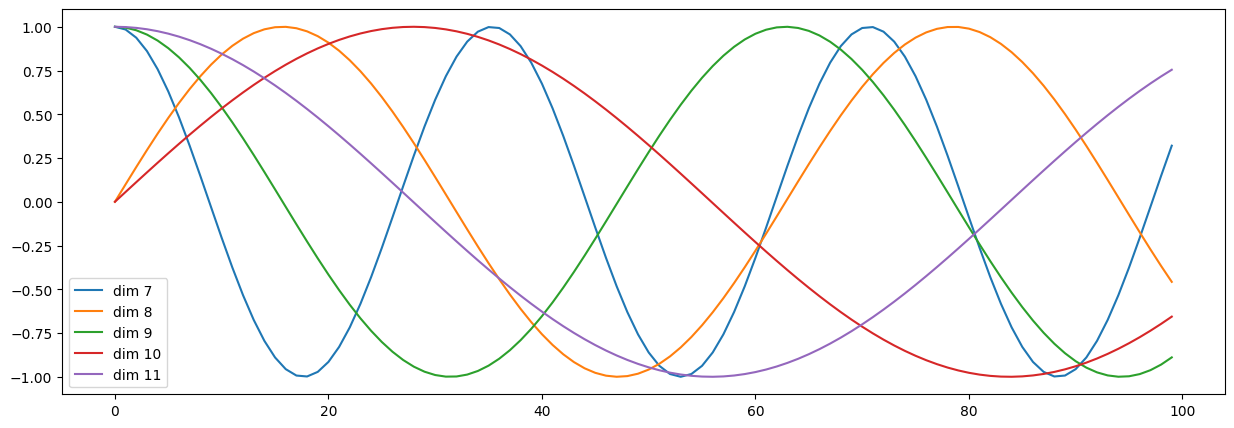

In [21]:
import matplotlib.pyplot as plt
import math
import numpy as np
DEVICE="cuda"
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(32, 0)
x = torch.zeros(1, 100, 32).to(DEVICE)
y = pe.forward(x)
plt.plot(np.arange(100), y[0, :, 7:12].data.cpu().numpy())
plt.legend(["dim %d"%p for p in [7,8,9,10,11]])

# 3 Create A Encoder-Decoder Transformer
We'll follow the 2017 paper and create and train an encoder-decoder transformer to translate German to English. 

## 3.1	Define The Transformer() Class 
To create an encoder-decoder transformer, we define a Transformer() class in the local module *transformer_util.py* as follows:

```python
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from torch import nn
# An encoder-decoder transformer
class Transformer(nn.Module):
    def __init__(self, encoder, decoder,
                 src_embed, tgt_embed, generator):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), 
                            memory, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        memory = self.encode(src, src_mask)
        output = self.decode(memory, src_mask, tgt, tgt_mask)
        return output
```

The transformer consists of an encoder and a decoder. The encoder converts the numerical representation of a German phrase into a continuous abstract representation (which we call *memory* in the above *Transformer()* class). The decoder then takes the output from the encoder and generates the translation in an autoregressive fashion: it generates one element at a time, based on the previously generated elements and the output from the encoder (more on this later). 

The encoder consists of N=6 identical encoder layers. The *Encoder()* class is defined as follows in the local module: 

```python
# Create an encoder
from copy import deepcopy
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = nn.ModuleList(
            [deepcopy(layer) for i in range(N)])
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
            output = self.norm(x)
        return output
```

The encoder consists of N=6 identical encoder layers. We employ a residual connection here: the input to the encoder layer is added to the output of the encoder layer. After that, we apply a normalization layer to the sum. The normalization layer normalizes each of the inputs in a batch independently across all features so that they all have zero mean and unit standard deviation. This helps stabilize training. Specifically, we define the *EncoderLayer()* class and the *LayerNorm()* class in the local module as follows:

```python
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = nn.ModuleList([deepcopy(
        SublayerConnection(size, dropout)) for i in range(2)])
        self.size = size  

    def forward(self, x, mask):
        x = self.sublayer[0](
            x, lambda x: self.self_attn(x, x, x, mask))
        output = self.sublayer[1](x, self.feed_forward)
        return output 
    
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        output = x + self.dropout(sublayer(self.norm(x)))
        return output  

class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True) 
        std = x.std(-1, keepdim=True)
        x_zscore = (x - mean) / torch.sqrt(std ** 2 + self.eps)
        output = self.a_2*x_zscore+self.b_2
        return output
```

The decoder in the transformer consists of N=6 identical decoder layers. Each decoder layer consists of a multi-head self-attention layer and a basic, position-wise, fully connected feed-forward network with residual connections, as shown on the right side of Figure 2.4. In addition to the above two sublayers, each decoder layer also has a third sub-layer that applies multi-head attention over the encoder stack’s output. Furthermore, the decoder stack’s self-attention sub-layer is masked to prevent positions from attending to subsequent positions. The mask forces the model to use previous elements in a sequence to predict later elements. To start with, the decoder takes the English phrase as the input: the decoder converts the English tokens in the phrase into word embedding and positional embedding and add the two embeddings before feeding the sum to the decoder layers.

Specifically, the *Decoder()* class is defined in the local module as follows:

```python
# Create a decoder
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = nn.ModuleList(
            [deepcopy(layer) for i in range(N)])
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        output = self.norm(x)
        return output
```

Similar to what we did with the encoder layers, we apply residual connection and layer normalization in each decoder layer. The decoder layer is defined as follows: 

```python
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn,
                 feed_forward, dropout):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = nn.ModuleList([deepcopy(
        SublayerConnection(size, dropout)) for i in range(3)])

    def forward(self, x, memory, src_mask, tgt_mask):
        x = self.sublayer[0](x, lambda x: 
                 self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x:
                 self.src_attn(x, memory, memory, src_mask))
        output = self.sublayer[2](x, self.feed_forward)
        return output 
```

## 3.2. The Attention Mechanism
While there are different attention mechanisms, we'll use the scaled dot product attention (SDPA). The SDPA attention mechanism uses query, key, and value to calculate the relationships among elements in a sequence. It assigns scores to show how an element in a sequence is related to all other elements. Specifically, we calculate the attention score as follows: 
$$AttentionScore(Q,K)=\frac{Q* K_{transpose}}{\sqrt{d_k}}$$
where $d_k$ is the dimension of the key. 

See Figure 2.5 for an illustration of how the attention score is calculated.


<img src="https://gattonweb.uky.edu/faculty/lium/gai/attn.jpg">

Figure 2.5. The scaled dot product attention mechanism (Source: Attention Is All You Need, Vaswani et al 2017)

The *attention()* function is defined in the local module as follows:

```python
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, 
              key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = nn.functional.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn
```

Instead of using one set of query, key, and value vectors, the transformer model uses a concept called multi-head attention. Our 256-dimensional query, key, and value vectors are split into 8 heads, and each head has a set of query, key, and value vectors with dimensions of 32 (because 256/8=32). Each head pays attention to different parts or aspects of the input, enabling the model to capture a broader range of information and form a more detailed and contextual understanding of the input data.

<img src="https://gattonweb.uky.edu/faculty/lium/gai/multihead.jpg">

Figure 2.6: Multi-head attention (Source: Attention Is All You Need, Vaswani et al 2017)

The *MultiHeadedAttention()* class is defined in the local module as follows:

```python
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = nn.ModuleList([deepcopy(
            nn.Linear(d_model, d_model)) for i in range(4)])
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)  
        query, key, value = [l(x).view(nbatches, -1, self.h,
           self.d_k).transpose(1, 2)
         for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout)
        x = x.transpose(1, 2).contiguous().view(
            nbatches, -1, self.h * self.d_k)
        output = self.linears[-1](x)
        return output 
```

## 3.3.	Position-Wise Feed Forward Networks
Each encoder layer and decoder layer also contains a feed forward sublayer. However, unlike regular fully connected dense layers, the neural network processes each embedding independently. It doesn't treat the sequence of embeddings as a single vector. Therefore, we often call it a position-wide feed forward network (or a 1-D convolutional network). 

We define a *PositionwiseFeedForward()* class in the local module as follows:

```python
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h1 = self.w_1(x)
        h2 = self.dropout(h1)
        return self.w_2(h2)   
```

## 3.4. Put All the Pieces Together to Create A Language Translator
Finally, we define a *Generator()* class in the local module to generate the most likely next token. The class is defined as follows:

```python
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        out = self.proj(x)
        probs = nn.functional.log_softmax(out, dim=-1)
        return probs   
```

The output of the *Generator()* class are probabilities for all the indexes corresponding to the tokens in the target language. This allows the model to predict one token at a time in an autoregressive fashion, based on previously generated tokens and the output from the encoder. 

Now we are ready to put all the pieces together and create our Transformer model. The *create_model()* function defined in the local module accomplishes that:

```python
# create the model
def create_model(src_vocab, tgt_vocab, N, d_model,
                 d_ff, h, dropout=0.1):
    attn=MultiHeadedAttention(h, d_model).to(DEVICE)
    ff=PositionwiseFeedForward(d_model, d_ff, dropout).to(DEVICE)
    pos=PositionalEncoding(d_model, dropout).to(DEVICE)
    model = Transformer(
        Encoder(EncoderLayer(d_model,deepcopy(attn),deepcopy(ff),
                             dropout).to(DEVICE),N).to(DEVICE),
        Decoder(DecoderLayer(d_model,deepcopy(attn),
             deepcopy(attn),deepcopy(ff), dropout).to(DEVICE),
                N).to(DEVICE),
        nn.Sequential(Embeddings(d_model, src_vocab).to(DEVICE),
                      deepcopy(pos)),
        nn.Sequential(Embeddings(d_model, tgt_vocab).to(DEVICE),
                      deepcopy(pos)),
        Generator(d_model, tgt_vocab)).to(DEVICE)
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model.to(DEVICE)
```

Finally, we import the *create_model()* function from the local module and construct a transformer so that we can use it to train the German to English translator:

In [22]:
from utils.transformer_util import create_model

model = create_model(src_vocab, tgt_vocab, N=6,
    d_model=256, d_ff=1024, h=8, dropout=0.1)

The original 2017 paper by Vaswani et al uses various combinations of hyperparameters when constructing the model. Here we choose a model dimension of 256 with 8 heads. 

# 4. Train the German to English Translator 

We'll train the transformer we created in the last section by using the batches of German to English translations that we prepared earlier in this chapter. 

## 4.1 Loss Function and Optimizer
The original 2017 paper by Vaswani et al uses label smoothing during training. Label smoothing is a technique used to address overconfidence problems (the predicted probability is greater than the true probability) in classifications. 

We define the following class in the local module:

```python
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super().__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')  
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, 
               target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        output = self.criterion(x, Variable(true_dist,
                            requires_grad=False))
        return output
```

The optimizer we use is the Adam optimizer with $\beta_1=0.9$, $\beta_2=0.98$, and $\epsilon=10^{-9}$. We define the *NoamOpt()* class in the local module to change the learning rate during the training process:

```python
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        if step is None:
            step = self._step
        output = self.factor * (self.model_size ** (-0.5) *
        min(step ** (-0.5), step * self.warmup ** (-1.5)))
        return output
```

We create the optimizer for training as follows:

In [23]:
from utils.transformer_util import NoamOpt

optimizer = NoamOpt(256, 1, 2000, torch.optim.Adam(
    model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

To create the loss function for training, we first define the following class in the local module:

```python
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.float()
```

We then define the loss function as follows:

In [24]:
from utils.transformer_util import (LabelSmoothing,
       SimpleLossCompute)

criterion = LabelSmoothing(tgt_vocab, 
                           padding_idx=0, smoothing=0.0)
loss_func = SimpleLossCompute(
            model.generator, criterion, optimizer)

Next, we'll train the transformer by using the data we prepared earlier in the chapter. 

## 4.2 The Training Process
We'll train the model for 50 epochs. We'll calculate the loss and the number of tokens from each batch. After each epoch, we calculate the average loss in the epoch as the ratio between the total loss and the total number of tokens:

In [25]:
# train for 50 epochs
for epoch in range(50):
    model.train()
    tloss=0
    tokens=0
    for batch in batches:
        out = model(batch.src, batch.trg, 
                    batch.src_mask, batch.trg_mask)
        loss = loss_func(out, batch.trg_y, batch.ntokens)
        tloss += loss
        tokens += batch.ntokens
    print(f"Epoch {epoch}, average loss: {tloss/tokens}")
torch.save(model.state_dict(),"files/de2en.pth")  

Epoch 0, average loss: 7.327764987945557
Epoch 1, average loss: 4.581755638122559
Epoch 2, average loss: 3.838163375854492
Epoch 3, average loss: 3.285771131515503
Epoch 4, average loss: 2.777700185775757
Epoch 5, average loss: 2.423189640045166
Epoch 6, average loss: 2.170571804046631
Epoch 7, average loss: 1.9846889972686768
Epoch 8, average loss: 1.844849705696106
Epoch 9, average loss: 1.7068313360214233
Epoch 10, average loss: 1.5546057224273682
Epoch 11, average loss: 1.4246137142181396
Epoch 12, average loss: 1.314481496810913
Epoch 13, average loss: 1.2218602895736694
Epoch 14, average loss: 1.137252688407898
Epoch 15, average loss: 1.0677496194839478
Epoch 16, average loss: 1.0075922012329102
Epoch 17, average loss: 0.9548308253288269
Epoch 18, average loss: 0.9082555770874023
Epoch 19, average loss: 0.8636742234230042
Epoch 20, average loss: 0.8233748078346252
Epoch 21, average loss: 0.7873021960258484
Epoch 22, average loss: 0.7528077363967896
Epoch 23, average loss: 0.71990

The above training process takes about an hour if you are using a GPU. It may take several hours if you are using CPU training. Once the training is done, the model weights are saved as *de2en.pth* on your computer. Alternatively, you can download from my website https://gattonweb.uky.edu/faculty/lium/gai/de2en.zip. Unzip the file after downloading. 

## 4.3 Translate German to English with the Trained Model
Now that you have trained the transformer, you can use it to translate any German sentence to English. We define a function *de2en()* as follows: 

In [26]:
from utils.transformer_util import subsequent_mask

def de2en(ger):
    # tokenize the German sentence
    tokenized_ger=detokenizer(ger)
    # add beginning and end tokens
    tokenized_ger=["BOS"]+tokenized_ger+["EOS"]
    # convert tokens to indexes
    geridx=[de_word_dict.get(i,UNK) for i in tokenized_ger]  
    src=torch.tensor(geridx).long().to(DEVICE).unsqueeze(0)
    # create mask to hide padding
    src_mask=(src!=0).unsqueeze(-2)
    # encode the German sentence
    memory=model.encode(src,src_mask)
    # start translation in an autogressive fashion
    start_symbol=en_word_dict["BOS"]
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    translation=[]
    for i in range(100):
        out = model.decode(memory,src_mask,ys,
        subsequent_mask(ys.size(1)).type_as(src.data))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, torch.ones(1, 1).type_as(
            src.data).fill_(next_word)], dim=1)
        sym = en_idx_dict[ys[0, -1].item()]
        if sym != 'EOS':
            translation.append(sym)
        else:
            break
    # convert tokens to sentences
    trans=" ".join(translation)
    for x in '''?:;.,'("-!&)%''':
        trans=trans.replace(f" {x}",f"{x}")    
    return trans

I added explanations as comments in the above code cell. First, we use the tokenizer to convert the German sentence to tokens. We then add in the beginning token "BOS" and the end token "EOS". We use the dictionary *de_word_dict* we created earlier in the chapter to convert tokens to indexes. We also create a mask for the input indexes before feeding them to the encoder in the trained model. The encoder produces an abstract vector representation so the decoder understands the meaning of the German sentence.  

Based on the abstract vector representation of the German sentence produced by the encoder, the decoder in the trained model starts translation in an autoregressive manner, starting with the beginning token "BOS". In each time step, the decoder generates the most likely next token based on previously generated tokens, until the predicted token is "EOS", which signals the end of the sentence. 

Let's try to translate the first five German sentences in the list trainde:

In [27]:
model.load_state_dict(torch.load("files/de2en.pth",
                                map_location=DEVICE))
model.eval()

for i in range(5):
    print("original Eng:", trainen[i])
    print("original Ger:", trainde[i])
    print("translated Eng:", de2en(trainde[i]))

original Eng: Two young, White males are outside near many bushes.
original Ger: Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
translated Eng: Two young, White males are outside near many bushes.
original Eng: Several men in hard hats are operating a giant pulley system.
original Ger: Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.
translated Eng: Several men in hard hats are operating a giant pulley system.
original Eng: A little girl climbing into a wooden playhouse.
original Ger: Ein kleines Mädchen klettert in ein Spielhaus aus Holz.
translated Eng: A little girl climbing into a wooden playhouse.
original Eng: A man in a blue shirt is standing on a ladder cleaning a window.
original Ger: Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.
translated Eng: A man in a blue shirt is standing on a ladder cleaning a window.
original Eng: Two men are at the stove preparing food.
original Ger: Zwei Männer stehen am Herd und bereit

As you can see, the trained model translated the German phrases. If you compare the original English translation and that provided by the trained model, they are almost identical. 

# 5. Visualize Self-Attention and Cross-Attention
Let's visualize the attention mechanism so that we understand how tokens in a sentence are relate to each other. 

## 5.1. Self Attention in the Encoder Layers

We first define a mtx2df() function to convert the attention matrix into Pandas DataFrames.

In [28]:
import pandas as pd

def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    "convert a matrix to a dataframe with row & column indices"
    return pd.DataFrame(
        [
        (
        r,
        c,
        float(m[r, c]),
        "%.3d %s"
        % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
        "%.3d %s"
        % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
        )
        for r in range(m.shape[0])
        for c in range(m.shape[1])
        if r < max_row and c < max_col
        ],
        columns=["row","column","value","row_token","col_token"],
    )

We then define an attn_map() function to convert attention to charts in the altair library. 

In [29]:
import altair as alt

def attn_map(attn,layer,head,row_tokens,col_tokens,max_dim=30):
    df = mtx2df(
        attn[0, head].data,
        max_dim,
        max_dim,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
        x=alt.X("col_token", axis=alt.Axis(title="")),
        y=alt.Y("row_token", axis=alt.Axis(title="")),
        color="value",
        tooltip=["row","column","value","row_token","col_token"],
        )
        .properties(height=400, width=400)
        .interactive()
    )

Now we can visualize the self-attention in the encoder layers. There are 6 layers and each layer has 8 head. So there are a total of 48 self-attention matrixes. We select layer 1 and head 2:

In [30]:
layer=0
head=1
attn=model.encoder.layers[layer].self_attn.attn 
n_heads = attn.shape[1]
charts = [
    attn_map(
        attn,
        0,
        h,
        row_tokens=tokenized_de, 
        col_tokens=tokenized_de,
        max_dim=len(tokenized_de),
    )
    for h in range(n_heads)
]
plots=alt.vconcat(
    charts[head]
).properties(title=f"Layer {layer+1} head {head+1}")
plots.show()
plots.save("files/encoder_self_attn.png")

alt.VConcatChart(...)

You should see an image as shown in Figure 2.1.

The self-attention is the strongest along the main diagonal, which means most tokens are strongly related to itself. However, we also noticed that some tokens are meaningfully related to other tokens. For example, junge is related strongly to Zwei junge weiße. The tokens vieler and Büsche are also paying attention to each other. 

## 5.2. Self Attention in the Decoder Layers
We can visualize the self-attention in the decoder layer as follows: 

In [31]:
layer=0
head=5
attn=model.decoder.layers[layer].self_attn.attn 
n_heads = attn.shape[1]
charts = [
    attn_map(
        attn,
        0,
        h,
        row_tokens=tokenized_en,
        col_tokens=tokenized_en,
        max_dim=len(tokenized_en),
    )
    for h in range(n_heads)
]
plots=alt.vconcat(
    charts[head]
).properties(title=f"Layer {layer+1} head {head+1}")
plots.show()
plots.save("files/decoder_self_attn.png")

alt.VConcatChart(...)

You should see an image as shown in Figure 2.2.

The tokens Two and young are closely related. The token "," is related to "white" so the model understand that the comma is used to add in another adjective, white. The token "males" is related to "," and "white".  

## 5.3 Cross Attention
Now, we can see how the German tokens and English tokens are related. 

In [32]:
layer=2
head=0
attn=model.decoder.layers[layer].src_attn.attn
n_heads = attn.shape[1]
charts = [
    attn_map(
        attn,
        0,
        h,
        row_tokens=tokenized_en, 
        col_tokens=tokenized_de,
        max_dim=max(len(tokenized_en),len(tokenized_de)),
    )
    for h in range(n_heads)
]
plots=alt.vconcat(
    charts[head]
).properties(title=f"Layer {layer + 1}")
plots.show()
plots.save("files/cross_attn.png")

alt.VConcatChart(...)

You should see an image as shown in Figure 2.3. 

The English token "Two" is related to the two German tokens "Zwei junge". The German token "Männer" is related to two English tokens "," and "white". The English token "near" is related to German tokens "Nähe vieler Büsche". These are all meaningful relations between the two languages. This indicates that the attention mechanism in the trained model is able to identify the relation between tokens in sentences. 